In [153]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [154]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    #### Region with pdf > 0
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i],min = 0, max=L[i])
    return x


In [155]:
N_Agents = 2
in_dim = 2
batch_size = 256
n_samples = 2048
timesteps = 30
lam = 0.5
k_max = 32
control_energy_reg = 0#1e-3#1e-6 ### regularization on maximum control energy
u_max = 1000 # does not do anything currently
thres = 0.1#1e-2 ### softness on constraint (will penalize when this much outside of rect)
dropout = 0


In [156]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    # = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)
    #return np.where((x > 0.6) & (x < 0.9),3, 0)
max_pdf = 5 / 3

In [157]:
from densities import uniform_rect_regions as pdf
import functools
region  = np.array([[[0, 0.3], [0, 0.3]],
                    [[0.6, 0.9], [0.7, 0.9]]])
region  = np.array([[[0, 1.], [0, 1.]]])
custom_pdf = functools.partial(pdf, regions=region)

In [158]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
model.init_hidden(batch_size = batch_size)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = 5/3, num_samples = 10000)


calulcated sigma: 0.1


torch.Size([256, 32, 32])
model: tensor([[[2.9315e+00, 2.8911e+00, 2.6187e+00,  ..., 8.8322e-02,
          4.8866e-02, 2.4740e-02],
         [2.7828e+00, 2.7445e+00, 2.4859e+00,  ..., 1.0471e-01,
          5.8687e-02, 3.0048e-02],
         [2.3807e+00, 2.3479e+00, 2.1266e+00,  ..., 1.1316e-01,
          6.4164e-02, 3.3181e-02],
         ...,
         [1.9570e-12, 9.7741e-12, 4.4599e-11,  ..., 1.9112e+00,
          2.2331e+00, 2.3516e+00],
         [3.6155e-13, 1.8226e-12, 8.4069e-12,  ..., 1.9335e+00,
          2.2598e+00, 2.3802e+00],
         [6.0577e-14, 3.0853e-13, 1.4402e-12,  ..., 1.8362e+00,
          2.1463e+00, 2.2608e+00]],

        [[2.7314e+00, 2.6554e+00, 2.3463e+00,  ..., 1.3017e-02,
          1.5115e-02, 1.5818e-02],
         [2.6256e+00, 2.5667e+00, 2.2870e+00,  ..., 2.9028e-02,
          3.3724e-02, 3.5309e-02],
         [2.2834e+00, 2.2493e+00, 2.0277e+00,  ..., 5.9045e-02,
          6.8632e-02, 7.1894e-02],
         ...,
         [7.3926e-12, 3.2377e-11, 1.3543e-10, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [700/700], Loss: 0.051723, lr: 0.001000


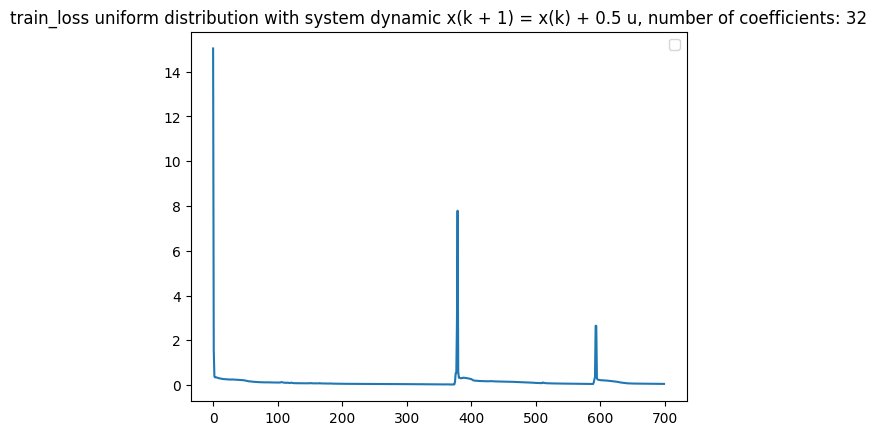

Training Complete!


In [159]:
############ Empircally we need loss < 0.01
import time
criterion.verbose = True
epochs = 700  # Number of epochs to train
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
decreased = False
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, eps = 1e-4)
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        outputs, control = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty # punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if show:
            show = False
            criterion.verbose = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)    
    avg_loss = running_loss / (n_samples // batch_size)
    ### He gets stuck here and often times not unstuck!
    if avg_loss < 0.011 and not decreased:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        decreased = True
    #if avg_loss < 0.009:
    #    break

    #scheduler.step(avg_loss) #### In our case test loss is the same as train loss
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}, lr: {optimizer.param_groups[0]['lr']:6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u, number of coefficients: {criterion.k_compare}')
plt.legend()
plt.show()
print("Training Complete!")

In [166]:
criterion.verbose = True
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion(x = outs, u = control)
#print(criterion.c)

torch.Size([1, 32, 32])
model: tensor([[[0.1001, 0.1450, 0.1953,  ..., 0.2312, 0.1865, 0.1391],
         [0.1418, 0.2011, 0.2657,  ..., 0.3086, 0.2471, 0.1832],
         [0.1877, 0.2600, 0.3363,  ..., 0.3919, 0.3122, 0.2303],
         ...,
         [0.2200, 0.2785, 0.3397,  ..., 0.3963, 0.3308, 0.2580],
         [0.1532, 0.1959, 0.2428,  ..., 0.2837, 0.2373, 0.1856],
         [0.0973, 0.1262, 0.1599,  ..., 0.1844, 0.1544, 0.1210]]],
       grad_fn=<CopySlices>) target: tensor([[0.1422, 0.1795, 0.2142,  ..., 0.2330, 0.1955, 0.1545],
        [0.1803, 0.2276, 0.2714,  ..., 0.2918, 0.2448, 0.1935],
        [0.2155, 0.2721, 0.3245,  ..., 0.3457, 0.2901, 0.2293],
        ...,
        [0.2239, 0.2844, 0.3403,  ..., 0.3282, 0.2766, 0.2205],
        [0.1883, 0.2395, 0.2870,  ..., 0.2757, 0.2319, 0.1847],
        [0.1502, 0.1913, 0.2295,  ..., 0.2186, 0.1836, 0.1460]])


tensor(0.0519, grad_fn=<AddBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


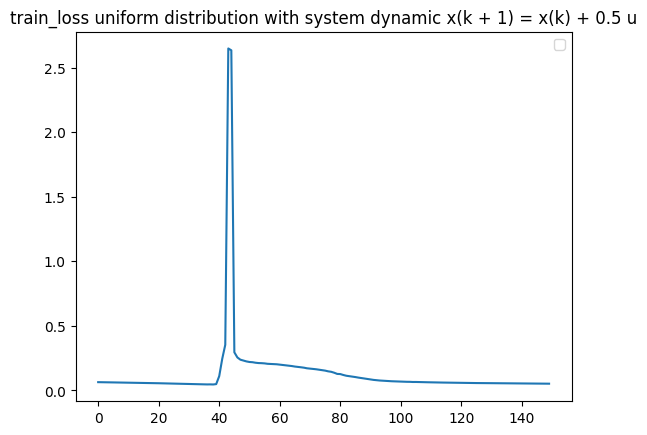

Training Complete!


In [167]:
plt.plot(train_loss[-150:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

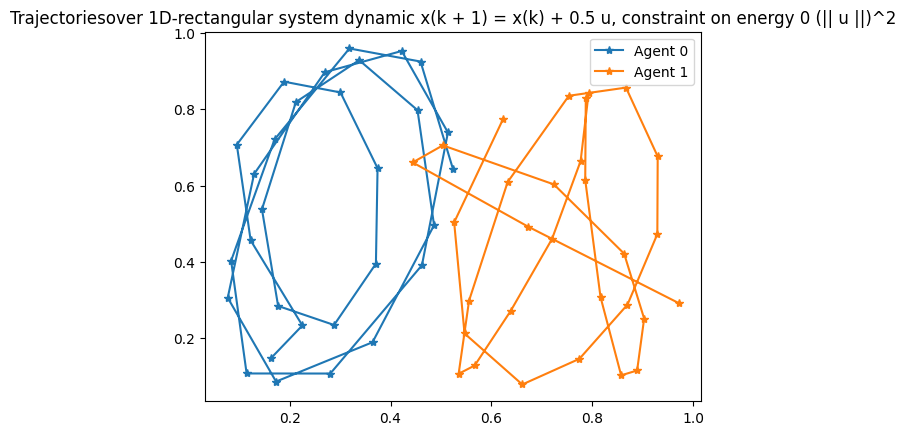

torch.Size([1, 32, 32])
model: tensor([[[0.0930, 0.1283, 0.1627,  ..., 0.0511, 0.0350, 0.0226],
         [0.1410, 0.1945, 0.2465,  ..., 0.0908, 0.0640, 0.0424],
         [0.1958, 0.2702, 0.3427,  ..., 0.1503, 0.1088, 0.0736],
         ...,
         [0.1791, 0.2552, 0.3367,  ..., 0.1947, 0.1367, 0.0872],
         [0.1359, 0.1946, 0.2586,  ..., 0.1324, 0.0930, 0.0594],
         [0.0944, 0.1359, 0.1823,  ..., 0.0829, 0.0582, 0.0372]]],
       grad_fn=<CopySlices>) target: tensor([[0.1422, 0.1795, 0.2142,  ..., 0.2330, 0.1955, 0.1545],
        [0.1803, 0.2276, 0.2714,  ..., 0.2918, 0.2448, 0.1935],
        [0.2155, 0.2721, 0.3245,  ..., 0.3457, 0.2901, 0.2293],
        ...,
        [0.2239, 0.2844, 0.3403,  ..., 0.3282, 0.2766, 0.2205],
        [0.1883, 0.2395, 0.2870,  ..., 0.2757, 0.2319, 0.1847],
        [0.1502, 0.1913, 0.2295,  ..., 0.2186, 0.1836, 0.1460]])


tensor(0.0518, grad_fn=<AddBackward0>)

In [175]:
model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    trajectory = outs[:,:,j,:].squeeze().detach()
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='*', linestyle='-', label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)


In [176]:
import uuid
import os
random_id = str(uuid.uuid4())[:8]
filename = f'0.1,0.1_sigma_2Agents_region_multiple_Agents{random_id}.pth'
path = os.path.join('models' , filename)
torch.save(model.state_dict(), path)
print(f"Model saved with filename: {filename}")

Model saved with filename: 0.1,0.1_sigma_2Agents_region_multiple_Agentsc6d95368.pth


In [164]:
ev = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32 , depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
ev.load_state_dict(torch.load(path))

<All keys matched successfully>

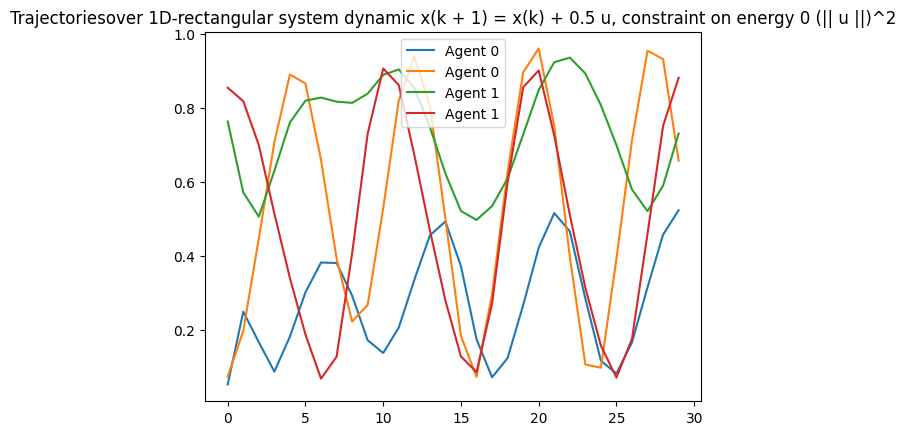

torch.Size([1, 32, 32])
model: tensor([[[0.1980, 0.2474, 0.2826,  ..., 0.0597, 0.0430, 0.0292],
         [0.2553, 0.3205, 0.3685,  ..., 0.1043, 0.0768, 0.0531],
         [0.3062, 0.3869, 0.4483,  ..., 0.1693, 0.1277, 0.0899],
         ...,
         [0.1580, 0.2146, 0.2698,  ..., 0.4700, 0.3710, 0.2684],
         [0.1024, 0.1392, 0.1755,  ..., 0.3606, 0.2845, 0.2059],
         [0.0602, 0.0819, 0.1035,  ..., 0.2549, 0.2007, 0.1451]]],
       grad_fn=<CopySlices>) target: tensor([[0.1422, 0.1795, 0.2142,  ..., 0.2330, 0.1955, 0.1545],
        [0.1803, 0.2276, 0.2714,  ..., 0.2918, 0.2448, 0.1935],
        [0.2155, 0.2721, 0.3245,  ..., 0.3457, 0.2901, 0.2293],
        ...,
        [0.2239, 0.2844, 0.3403,  ..., 0.3282, 0.2766, 0.2205],
        [0.1883, 0.2395, 0.2870,  ..., 0.2757, 0.2319, 0.1847],
        [0.1502, 0.1913, 0.2295,  ..., 0.2186, 0.1836, 0.1460]])


tensor(0.0521, grad_fn=<AddBackward0>)

In [165]:
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
ev.init_hidden(batch_size = 1)
outs, control = ev(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)